In [1]:
from mm import *

In [53]:
best_params = {'value': 0.1858555762483131,
                'params_kandle_size': 12.0,
                'params_mfi_range': 1830.0,
                'params_mfi_value': 15.8}

In [2]:
df = pd.read_csv('../data/price-volume-minute_btc-usd.csv',header=None)
df.columns = ['price','volume','time']
df = df.astype({'time':'datetime64[ms]'}).set_index('time').sort_index()

In [54]:
def calc_mfi(df,kandle=12,mfi_range=1800):
    dd = df.copy()
    dd['price'] = dd['price'].rolling(kandle,1).mean()
    pmf = dd.where(dd['price'].diff() > 0).rolling(mfi_range,1).agg({'price':'sum','volume':'sum'}) 
    pmf = pmf['price'] * pmf['volume']
    nmf = dd.where(dd['price'].diff() < 0).rolling(mfi_range,1).agg({'price':'sum','volume':'sum'}) 
    nmf = nmf['price'] * nmf['volume']
    return 100 - 100/(1 + pmf/nmf)

In [55]:
def check_profit_probability(data,w8_period=1440,probability = True,profit = 0.05):
    if probability:
        return np.mean(data[0] < (data[:w8_period] * (1-profit)) )
    return any(data[0] < (data[:w8_period] * (1-profit)))

In [71]:
def validate_strategy(data,idx,sample_size=1000,**kwargs):
    return list(map(lambda i: check_profit_probability(data.loc[i:].values,**kwargs),np.random.choice(idx,sample_size)))

In [57]:
def trend_sampler(df,thr = .9,resampler = '24H'):
    if thr < 1:
        return df.resample(resampler).agg(['first','last']).where(lambda x: (x['last'] / x['first']) < thr).dropna().index
    else :
        return df.resample(resampler).agg(['first','last']).where(lambda x: (x['last'] / x['first']) > thr).dropna().index


In [58]:
# fig,ax = plt.subplots(2,1)
# idx = np.random.randint(df.shape[0]-1000)
# idx_df = df.iloc[idx-1000:idx+1000].index
# df.loc[idx_df,'price'].plot(ax=ax[0],title='Price')
# calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).plot(ax=ax[1],title='MFI',color='b')
# buy_idx = calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).where(lambda x: x < 20).dropna().index
# sell_idx = calc_mfi(df.loc[idx_df],kandle=5,mfi_range=5*14).where(lambda x: x > 80).dropna().index
# [ax[0].axvline(bidx,linestyle='--',alpha=0.3,color='g') for bidx in buy_idx]
# [ax[1].axvline(bidx,linestyle='--',alpha=0.3,color='g') for bidx in buy_idx]
# plt.tight_layout()
# (df.loc[sell_idx]['price'].resample('min').mean().fillna(method='bfill') - df.loc[buy_idx]['price'].resample('min').mean()).dropna().clip(-1,1).round().value_counts(normalize=True)

In [116]:
dfs = df['price'].loc['2019']

In [123]:
mfi_idx = calc_mfi(df.loc[dfs.index]).where(lambda x: x<30).dropna().index
rng_idx = np.random.choice(dfs.index,len(mfi_idx))
print(f'MFI point counts {len(mfi_idx)} \n')

MFI point counts 15493 



In [120]:
rng = Parallel(n_jobs=6, verbose=10)(delayed(validate_strategy)(data=dfs,idx=rng_idx,probability=False) for _ in range(1000))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Batch computation too fast (0.1951s.) Setting batch_size=2.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 108 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done 190 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done 254 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapse

In [124]:
mfi = Parallel(n_jobs=6, verbose=10)(delayed(validate_strategy)(data=dfs,idx=mfi_idx,probability=False) for _ in range(1000))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Batch computation too fast (0.1657s.) Setting batch_size=2.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 108 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done 160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done 190 tasks      | elapsed:    4.9s
[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 254 tasks      | elapsed:    6.5s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapse

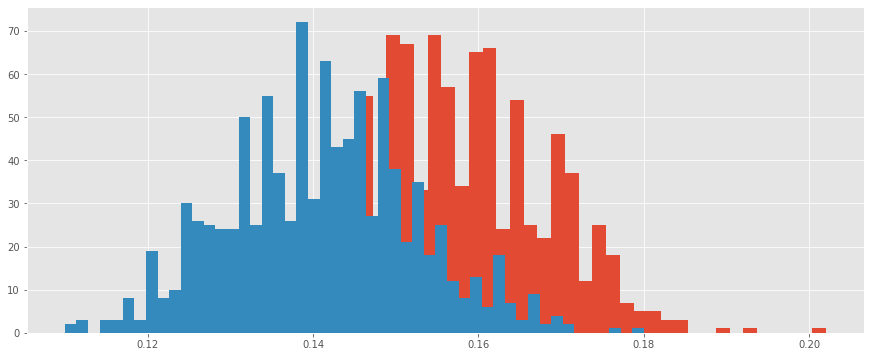

In [125]:
plt.hist(np.array(mfi).mean(axis=1),bins=50);
plt.hist(np.array(rng).mean(axis=1),bins=50);

In [126]:
np.array(rng).mean(axis=1).mean()

0.14091700000000001

In [127]:
np.array(mfi).mean(axis=1).mean()

0.156074

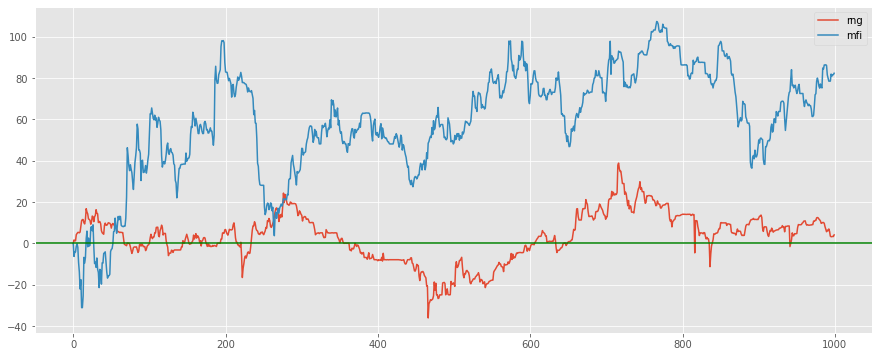

In [136]:
num_idx = np.random.randint(len(mfi_idx))
dfs.loc[rng_idx[num_idx]:].iloc[:1000].sub(dfs.loc[rng_idx[num_idx]]).reset_index(drop=True).plot()
dfs.loc[mfi_idx[num_idx]:].iloc[:1000].sub(dfs.loc[mfi_idx[num_idx]]).reset_index(drop=True).plot()
plt.legend(['rng','mfi'])
plt.axhline(0,color='g')

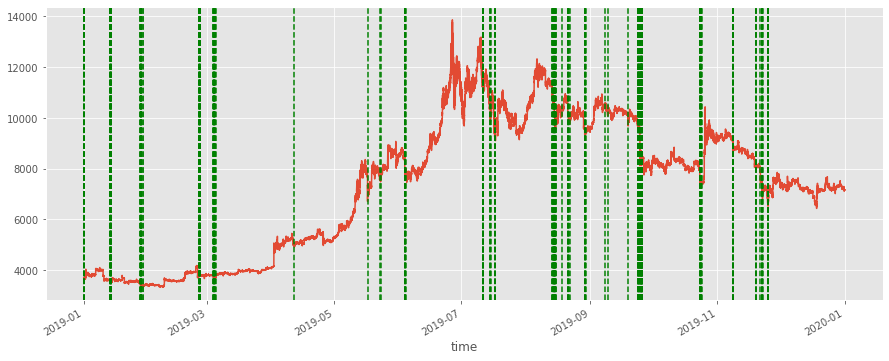

In [138]:
dfs.plot()
[ plt.axvline(i,color='g',linestyle='--') for i in np.random.choice(mfi_idx,200)];

In [17]:
# idx = np.datetime_as_string(np.random.choice(trend_sampler(df['price'].loc['2021'],thr=.9)),'D')
# df.loc[str(idx),'price'].plot()

In [18]:
import optuna

In [21]:
def hyp_obj(trial):
    
    kandle = trial.suggest_int('kandle_size',5,30)
    ma_range = trial.suggest_int('mfi_range',30,2000,30)
    mfi_value = trial.suggest_int('mfi_value',5,30)
    has_more = []
    rng_more = []
    for i in range(50):
        idx = np.random.randint(df.shape[0]-2000)
        idx_df = df.iloc[idx-2000:idx+2000].index
        buy_idx = calc_mfi(df.loc[idx_df],kandle=kandle,mfi_range=ma_range).where(lambda x: x < mfi_value).dropna().index
        try:
            has_more.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=buy_idx,probability=False)))
            rng_more.append(np.mean(validate_strategy(data=df.loc[idx_df,'price'],idx=np.random.choice(idx_df,len(buy_idx)),probability=False)))
        except:
            pass

    return np.mean(np.array(has_more) - np.array(rng_more))

In [22]:

study = optuna.create_study(direction='maximize')
study.optimize(hyp_obj, n_trials=100)


[I 2022-04-06 23:33:08,300] A new study created in memory with name: no-name-c2117b5f-d666-4f72-92fe-65a560b62060
[I 2022-04-06 23:33:48,897] Trial 0 finished with value: 0.07667600000000001 and parameters: {'kandle_size': 23, 'mfi_range': 270, 'mfi_value': 29}. Best is trial 0 with value: 0.07667600000000001.
[I 2022-04-06 23:34:13,559] Trial 1 finished with value: 0.2192466666666667 and parameters: {'kandle_size': 14, 'mfi_range': 1830, 'mfi_value': 10}. Best is trial 1 with value: 0.2192466666666667.
[I 2022-04-06 23:34:44,021] Trial 2 finished with value: 0.08387027027027026 and parameters: {'kandle_size': 16, 'mfi_range': 1650, 'mfi_value': 13}. Best is trial 1 with value: 0.2192466666666667.
[I 2022-04-06 23:35:00,649] Trial 3 finished with value: 0.15 and parameters: {'kandle_size': 6, 'mfi_range': 1560, 'mfi_value': 5}. Best is trial 1 with value: 0.2192466666666667.
[I 2022-04-06 23:35:31,643] Trial 4 finished with value: 0.06014736842105262 and parameters: {'kandle_size': 17,

In [52]:
study.trials_dataframe().loc[:,['value','params_kandle_size','params_mfi_range','params_mfi_value']].sort_values(by='value',ascending=False).iloc[:5].mean().to_dict()

{'value': 0.1858555762483131,
 'params_kandle_size': 12.0,
 'params_mfi_range': 1830.0,
 'params_mfi_value': 15.8}

In [39]:
study.trials_dataframe().sort_values(by='value',ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_kandle_size,params_mfi_range,params_mfi_value,state
1,1,0.219247,2022-04-06 23:33:48.898637,2022-04-06 23:34:13.559490,0 days 00:00:24.660853,14,1830,10,COMPLETE
89,89,0.185555,2022-04-07 00:18:35.651664,2022-04-07 00:19:08.185370,0 days 00:00:32.533706,10,1800,23,COMPLETE
24,24,0.178575,2022-04-06 23:45:53.891277,2022-04-06 23:46:28.409417,0 days 00:00:34.518140,11,1800,24,COMPLETE
78,78,0.175754,2022-04-07 00:13:28.887394,2022-04-07 00:13:51.151051,0 days 00:00:22.263657,13,1920,6,COMPLETE
15,15,0.170147,2022-04-06 23:40:26.999180,2022-04-06 23:40:59.695107,0 days 00:00:32.695927,12,1800,16,COMPLETE
...,...,...,...,...,...,...,...,...,...
50,50,-0.019155,2022-04-06 23:59:43.658906,2022-04-07 00:00:10.646154,0 days 00:00:26.987248,11,1860,16,COMPLETE
54,54,-0.022766,2022-04-07 00:01:57.952312,2022-04-07 00:02:32.300860,0 days 00:00:34.348548,19,1620,25,COMPLETE
92,92,-0.055143,2022-04-07 00:20:15.689151,2022-04-07 00:20:44.494900,0 days 00:00:28.805749,11,1830,21,COMPLETE
84,84,-0.062339,2022-04-07 00:15:59.698286,2022-04-07 00:16:28.146662,0 days 00:00:28.448376,15,1590,9,COMPLETE
